In [197]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from misc_tools.print_latex import print_tex
from collections import defaultdict

env = gym.make('Blackjack-v1', sab=True)


actions = {0:'Stick', 1:'Hit!'}
rewards = {-1:'Loss', 0:'draw', 1:'Win!'}
done = False
state,_ = env.reset()
while not done:
    hand, hand_dealer, has_ace = state
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)[:4]
    hand_new, hand_dealer_new, has_ace_new = state
    print(f'{hand = }, {hand_dealer = }, {has_ace = }, {actions[action] = }\n',
          f'{hand_new = }, {hand_dealer_new = }, {has_ace_new = }, {rewards[reward] = }, {done = }\n')

hand = 9, hand_dealer = 8, has_ace = False, actions[action] = 'Stick'
 hand_new = 9, hand_dealer_new = 8, has_ace_new = False, rewards[reward] = 'Loss', done = True



c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



State space $\{\text{current hand, dealers card, have usable ace}\}\in S


We examine a single episode consisting of $T$ time steps:

*   at time $i$ our agent was in state $s_i$, which may be visited at some other time $j$, so $s_i = s_j$
    $$(i,j) \in [0,1,\dots, T]$$
*   Trajectory:
    $$T = \{s_0,s_1,\dots,s_T\}$$
*   Rewards:
    $$R = \{r_0,r_1,\dots,r_{T-1}\}$$

*   reward $r_i$ is associated with transition $s_{i}\rightarrow s_{i+1}$ via action $a$
    $$r_i: s_{i}\overset{a}{\rightarrow} s_{i+1}$$
*   state $s_i$ has cumulative future reward  
    $$R(s_i) = \sum_i^{T-1} r_i$$

*   Thus value of an action $$q(s_i = s,a) = \sum_i^{T-1} r_i$$

We can get an average (estimated) reward for action-state pair $(a,s)$ by analyzing multiple episodes

*   $$\bar q(s,a) = \frac{1}{N_s} q^k(s,a)$$

# Naive MC approach. Gather all transitions.

In [198]:
policy = np.zeros(( 32, 12, 2, 2)) # hand, card dealer, has ace, actions probs distr: [1,0] = stick, [0,1] =hit
hit_limit = 20
policy[:hit_limit,:,:,1] = 1              # less than 20 -> hit 100%
policy[hit_limit:,:,:,0] = 1 
vals = np.zeros(( 32, 12, 2))
policy[hit_limit-1,1,1]

array([0., 1.])

In [199]:
def get_traj_N(N):
    trajs_all = []
    actions_all = []
    rewards_all = []
    for _ in range(N):
        
        state,_ = env.reset()
        trajs = [state]
        rewards = []
        actions = []
        while True:
            hand, hand_dealer, has_ace = state
            action = np.random.choice(np.arange(2), p = policy[hand,hand_dealer,int(has_ace)])
            state, reward, done, info = env.step(action)[:4]
            trajs.append(state)
            actions.append(action)
            rewards.append(reward)

            if done: break

        trajs_all.append(trajs)
        actions_all.append(actions)
        rewards_all.append(rewards)
    return trajs_all,actions_all,rewards_all


In [310]:

trajs_all,actions_all,rewards_all = get_traj_N(500_000)

visited_states = set()
for tr in trajs_all: visited_states.update(tr)

expected_vals = defaultdict(float)#{i:0 for i in visited_states}
num_visits = defaultdict(float)#{i:0 for i in visited_states}

def update_mean(arr_a_mean, arr_a_len, arr_b):
    return 1/(arr_a_len+len(arr_b)) * (arr_a_len*arr_a_mean + len(arr_b)*arr_b.mean())

def update_mean_single(arr_a_mean, arr_a_len, val):
    return 1/(arr_a_len+1) * (arr_a_len*arr_a_mean + val)

for tr, ac, rw in zip(trajs_all,actions_all,rewards_all):
    for i in range(len(rw)):
        s = tr[i]
        rews = np.array(rw[i:])
        if num_visits[s] == 0:
            expected_vals[s] = rews.mean()
        else:
            expected_vals[s] = update_mean(expected_vals[s], num_visits[s], rews)

        num_visits[s] += 1

#num_visits, expected_vals        

In [311]:
for (hand, hand_dealer, has_ace ), val in expected_vals.items(): 
    vals[hand, hand_dealer, has_ace] = val

Text(0.5, 0, 'State Value')

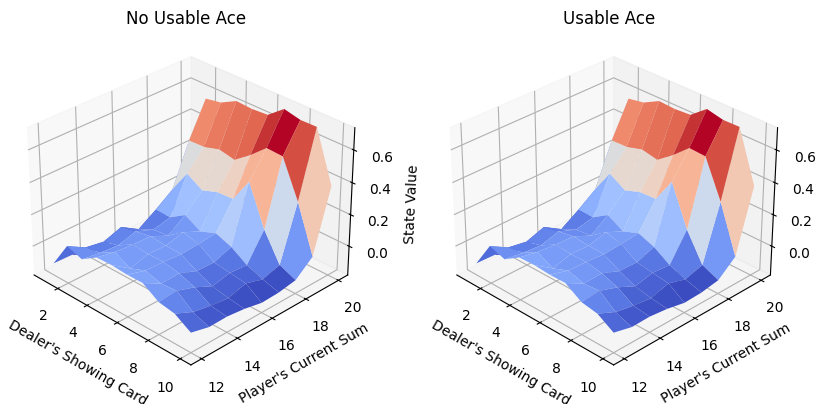

In [312]:
Z = vals[12:21,1:11,0]
x, y = np.meshgrid(np.arange(Z.shape[1])+1, np.arange(Z.shape[0])+12)
from matplotlib import cm
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(121, projection='3d')
ax.set_title('No Usable Ace')
surf = ax.plot_surface(x, y,Z, cmap=cm.coolwarm, linewidth=5, antialiased=True)

ax.view_init(ax.elev, -45)
ax.set_xlabel('Dealer\'s Showing Card')
ax.set_ylabel('Player\'s Current Sum')
ax.set_zlabel('State Value')
Z = vals[12:21,1:11,1]
ax = fig.add_subplot(122, projection='3d')
ax.set_title('Usable Ace')
surf = ax.plot_surface(x, y,Z, cmap=cm.coolwarm, linewidth=5, antialiased=True)

ax.view_init(ax.elev, -45)
ax.set_xlabel('Dealer\'s Showing Card')
ax.set_ylabel('Player\'s Current Sum')
ax.set_zlabel('State Value')

In [203]:
ab = np.arange(16)
split = 15
a = ab[:split]; b = ab[split:]
ab.mean() == 1/(len(a)+len(b)) * (len(a)*a.mean() + len(b)*b.mean()), ab.mean() == update_mean(a.mean(), len(a), b)

(True, True)

# An on-policy first-visit MC
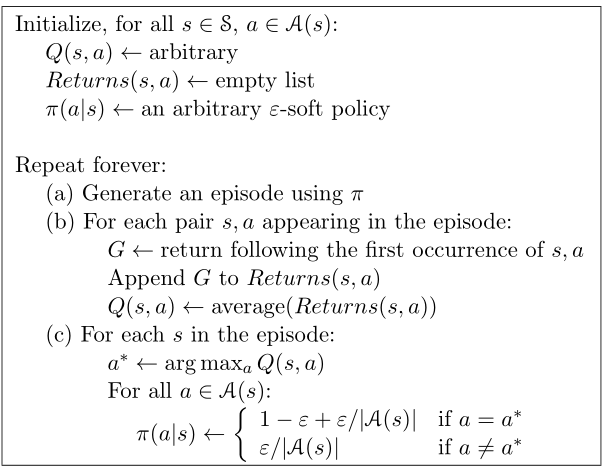

<b>NOTE: </b>In this definition exploration probability is divided between all actions, even greedy one

In [278]:
np.random.seed(2)
# 0 = stick. 1 = hit
CARDS_TOTAL_SCORE = 31
SOLO_CARD_MAX_VALUES = 11
NUM_ACTIONS = env.action_space.n

STATE_SHAPE = (CARDS_TOTAL_SCORE + 1, SOLO_CARD_MAX_VALUES + 1, NUM_ACTIONS)
STATE_SHAPE_EXTENDED = STATE_SHAPE + (NUM_ACTIONS,)
NUM_STATES_TOTAL = np.prod(STATE_SHAPE)

eps = 0.1

# define base epsilon-soft policy. fill with eps values
policy = np.ones(shape= (NUM_STATES_TOTAL,NUM_ACTIONS))*eps/(NUM_ACTIONS)

greedy =  np.random.randint(0,NUM_ACTIONS, size = NUM_STATES_TOTAL)
np.random.seed()
policy[np.arange(NUM_STATES_TOTAL),greedy] = (1-eps + eps/(NUM_ACTIONS))
policy = policy.reshape(STATE_SHAPE_EXTENDED)

Qsa = np.ones(STATE_SHAPE_EXTENDED)/2 # hand, opp card, usable ace, action

num_visits = defaultdict(int)

def off_policy_first_visit_MC(N = 1):

    for _ in range(N):
        
        state,_ = env.reset()
        trajs = []
        rewards = []
        # (a) Generate episode using pi 
        while True:
            on_hand, card_dealer, ace_usable = state
            pol = policy[on_hand,card_dealer,int(ace_usable)]
            action = np.random.choice(np.arange(NUM_ACTIONS), p = pol)
            state, reward, done = env.step(action)[:3]
            state_action = (on_hand,card_dealer,int(ace_usable)) + (action,)
            trajs.append(state_action)
            rewards.append(reward)
            #print(on_hand, card_dealer, ace_usable, policy[on_hand,card_dealer,int(ace_usable)],action,state,reward, done)
            if done: break
        
        # (b) update Q(s,a) mean.
        # get index of first occurrence of state in a trajectory. 
        # basically go from end to start and assign smaller index to duplicate
        # trajs = [0,1,2,3,2,1,2,3,4,5] ->
        # -> {0: 0, 1: 1, 2: 2, 3: 3, 4: 8, 5: 9}
        encontered_states = list(set(trajs))
        state_pos = {s:0 for s in encontered_states}
        for i,s in zip(reversed(range(len(trajs))),reversed(trajs)):
            state_pos[s] = i
        #print(encontered_states,trajs,rewards)
        for s in encontered_states:
            (on_hand,card_dealer,ace_usable, action) = s
            mean_reward = np.mean(rewards[state_pos[s]:])
            #print(mean_reward,state_pos[s])
            if num_visits[s] == 0:
                Qsa[s] = mean_reward
            else:
                Qsa[s] = update_mean_single(Qsa[s], num_visits[s], mean_reward)
            
            num_visits[s] += 1
            
        # (c) update policy

        for s in trajs:
            (on_hand,card_dealer,ace_usable, action) = s
            Qs = Qsa[s[:-1]] # probs or actions 
            #print(Qs,np.where(Qs == Qs.max())[0])
            a_best = np.random.choice(np.where(Qs == Qs.max())[0])  # for dups pick at random
            #print(Qs,a_best,policy[(on_hand,card_dealer,ace_usable)])
            policy[(on_hand,card_dealer,ace_usable)] = np.ones(NUM_ACTIONS)*eps/(NUM_ACTIONS)   # redef eps probs
            policy[(on_hand,card_dealer,ace_usable, a_best)] = (1-eps + eps/(NUM_ACTIONS))      # assign new greed
                    
            #print(policy[(on_hand,card_dealer,ace_usable)])
                    

    return state_pos,trajs


off_policy_first_visit_MC(1_500_000);


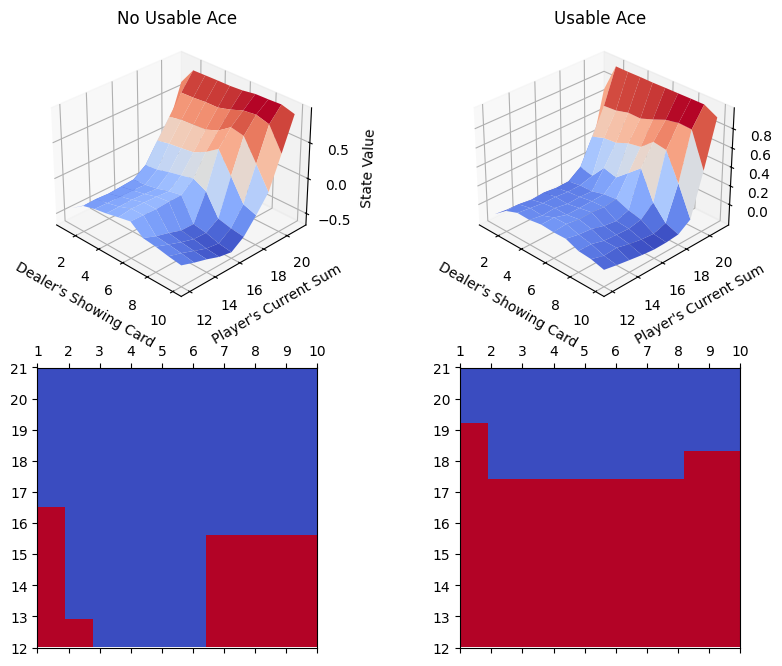

In [306]:
vp = Qsa.max(axis = -1)
min_hand = 12; max_hand = 22; min_deal = 1; max_deal = 11
ace_useable = 1; ace_unusable = 0
Z = vp[min_hand:max_hand,min_deal:max_deal,ace_unusable]
x, y = np.meshgrid(np.arange(Z.shape[1])+1, np.arange(Z.shape[0])+12)
from matplotlib import cm
fig, ax = plt.subplots(2, 2, figsize=(10, 8), subplot_kw={'projection': '3d'})

ax[0,0].set_title('No Usable Ace')
ax[0,0].plot_surface(x, y,Z, cmap=cm.coolwarm, linewidth=5, antialiased=True)
ax[0,0].view_init(ax[0,0].elev, -45)
ax[0,0].set_xlabel('Dealer\'s Showing Card')
ax[0,0].set_ylabel('Player\'s Current Sum')
ax[0,0].set_zlabel('State Value')

Z = vp[min_hand:max_hand,min_deal:max_deal,ace_useable]

ax[0,1].set_title('Usable Ace')
ax[0,1].plot_surface(x, y,Z, cmap=cm.coolwarm, linewidth=5, antialiased=True)
ax[0,1].view_init(ax[0,0].elev, -45)
ax[0,1].set_xlabel('Dealer\'s Showing Card')
ax[0,1].set_ylabel('Player\'s Current Sum')
ax[0,1].set_zlabel('State Value')

for i in range(2):
    ax[1, i].remove()
    ax[1, i] = fig.add_subplot(2, 2, i + 3)


Z = np.argmax(Qsa, axis=-1)[min_hand:max_hand,min_deal:max_deal,ace_unusable]

ax[1,0].matshow(Z, cmap=cm.coolwarm, extent =[x.min(), x.max(), y.max(), y.min()])
ax[1,0].invert_yaxis()

Z = np.argmax(Qsa, axis=-1)[min_hand:max_hand,min_deal:max_deal,ace_useable]
ax[1,1].matshow(Z, cmap=cm.coolwarm, extent =[x.min(), x.max(), y.max(), y.min()])
ax[1,1].invert_yaxis()

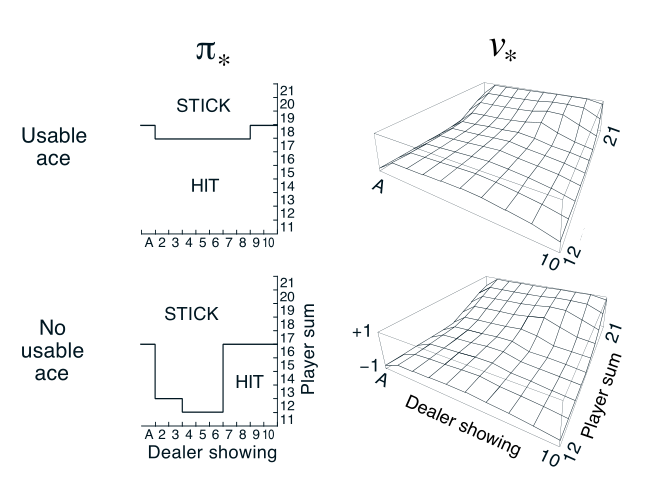

Figure 5.5 in the book by Sutton and Bartol
